## Import libraries


In [127]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree


## KNN Implementation


In [128]:
class KNNClassifier:
    def __init__(self, k):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = np.array(y)

    def predict(self, X):
        predictions = []
        for x in X:
            distances = np.sqrt(np.sum((self.X_train - x)**2, axis=1))    # calculate euclid. dist.
            
            # get k nearest neighbors
            k_indices = np.argsort(distances)[:self.k]          
            k_nearest_labels = self.y_train[k_indices]
            
            prediction = np.bincount(k_nearest_labels).argmax()
            predictions.append(prediction)
        return np.array(predictions)


## Load and preprocess

#### TO DO:

###### 1-Load data

###### 2-Sample equal number of samples from each class. find a reasonable number.

###### 3-Encode categorical values

###### 4-Keep these columns and drop the rest : grade, term, home_ownership, emp_length

###### 5-Split data to train, validation and test set

###### 6-Scale the data(normalization)

###### 7-The target column is "bad_loans"


In [129]:
def load_and_preprocess_data(path):
    df = pd.read_csv(path)
    cols = ["grade", "term", "home_ownership", "emp_length", "bad_loans"]
    df = df[cols].copy()    # use .copy method to prevent pd to place a view instead of a complete dataframe

    min_class_count = min(df['bad_loans'].value_counts())    # 1 is less, use it as the count of samples
    df_balanced = pd.concat([
        df[df['bad_loans'] == 0].sample(min_class_count),
        df[df['bad_loans'] == 1].sample(min_class_count)
    ])
    # df_balanced now have the same amount of records with values 0 and 1

    # print(df_balanced.head())

    le = LabelEncoder()
    for col in ['grade', 'term', 'home_ownership', 'emp_length']:
        df_balanced[col] = le.fit_transform(df_balanced[col].astype(str))
    
    # print(df_balanced.head())

    X = df_balanced.drop('bad_loans', axis=1)
    y = df_balanced['bad_loans']
    
    X_train, X_non_train, y_train, y_non_train = train_test_split(X, y, test_size=0.3, random_state=42)    # leaves 30% of data for test and valid.
    X_val, X_test, y_val, y_test = train_test_split(X_non_train, y_non_train, test_size=0.5, random_state=42)    # 15% for valid. and 15% test
    
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)    # calculate mean and variance here to use later for valid. and test
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, X.columns



#### Training functions


In [130]:
def train_decision_tree(X_train, y_train, d):    
    model = DecisionTreeClassifier(max_depth=d, random_state=42)
    model.fit(X_train, y_train)
    return model

# Function to train KNN classifier
def train_knn(X_train, y_train, k):
    model = KNNClassifier(k=k)
    model.fit(X_train, y_train)
    return model

def train_adaboost(X_train, y_train, n_estimators):
    model = AdaBoostClassifier(n_estimators=n_estimators, random_state=42)
    model.fit(X_train, y_train) 
    return model

def train_rf(X_train, y_train, n_trees, max_depth):
    model = RandomForestClassifier(n_estimators=n_trees, max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)
    return model

In [131]:
def compare_models(dt_accuracy, knn_accuracy, ab_accuracy, rf_accuracy):
    models = ['Decision Tree', 'KNN','Adaboost', 'Random Forest']
    accuracies = [dt_accuracy, knn_accuracy, ab_accuracy,rf_accuracy]

    plt.figure(figsize=(8, 6))
    plt.bar(models, accuracies)
    plt.title('Model Comparison - Test Accuracy')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    for i, v in enumerate(accuracies):
        plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
    plt.show()

## The main function

#### TO DO:

###### Use the defined functions to load the dataset and train the models.

###### You should optimize the hyperparameters. Maximum depth for DT and k for KNN and n_estimators for Adaboost.

###### Find the best DT, KNN, Adaboost and RF model and report the test accuracy.


C:\Users\Pooya Tarashi\AppData\Local\Temp\ipykernel_17480\606633172.py:2: DtypeWarning: Columns (19,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


Best K found for KNN:  869
Best depth found fot DT:  5
best no. of trees found for RF: 50, best depth: 5
best n_estimators found for AdaBoost: 50


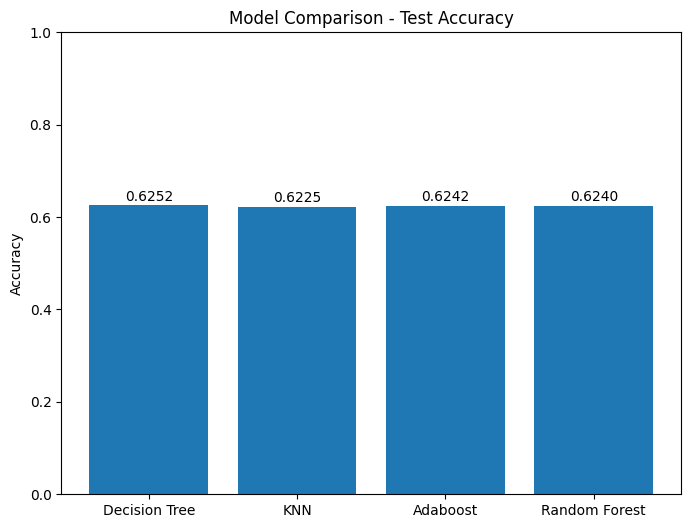

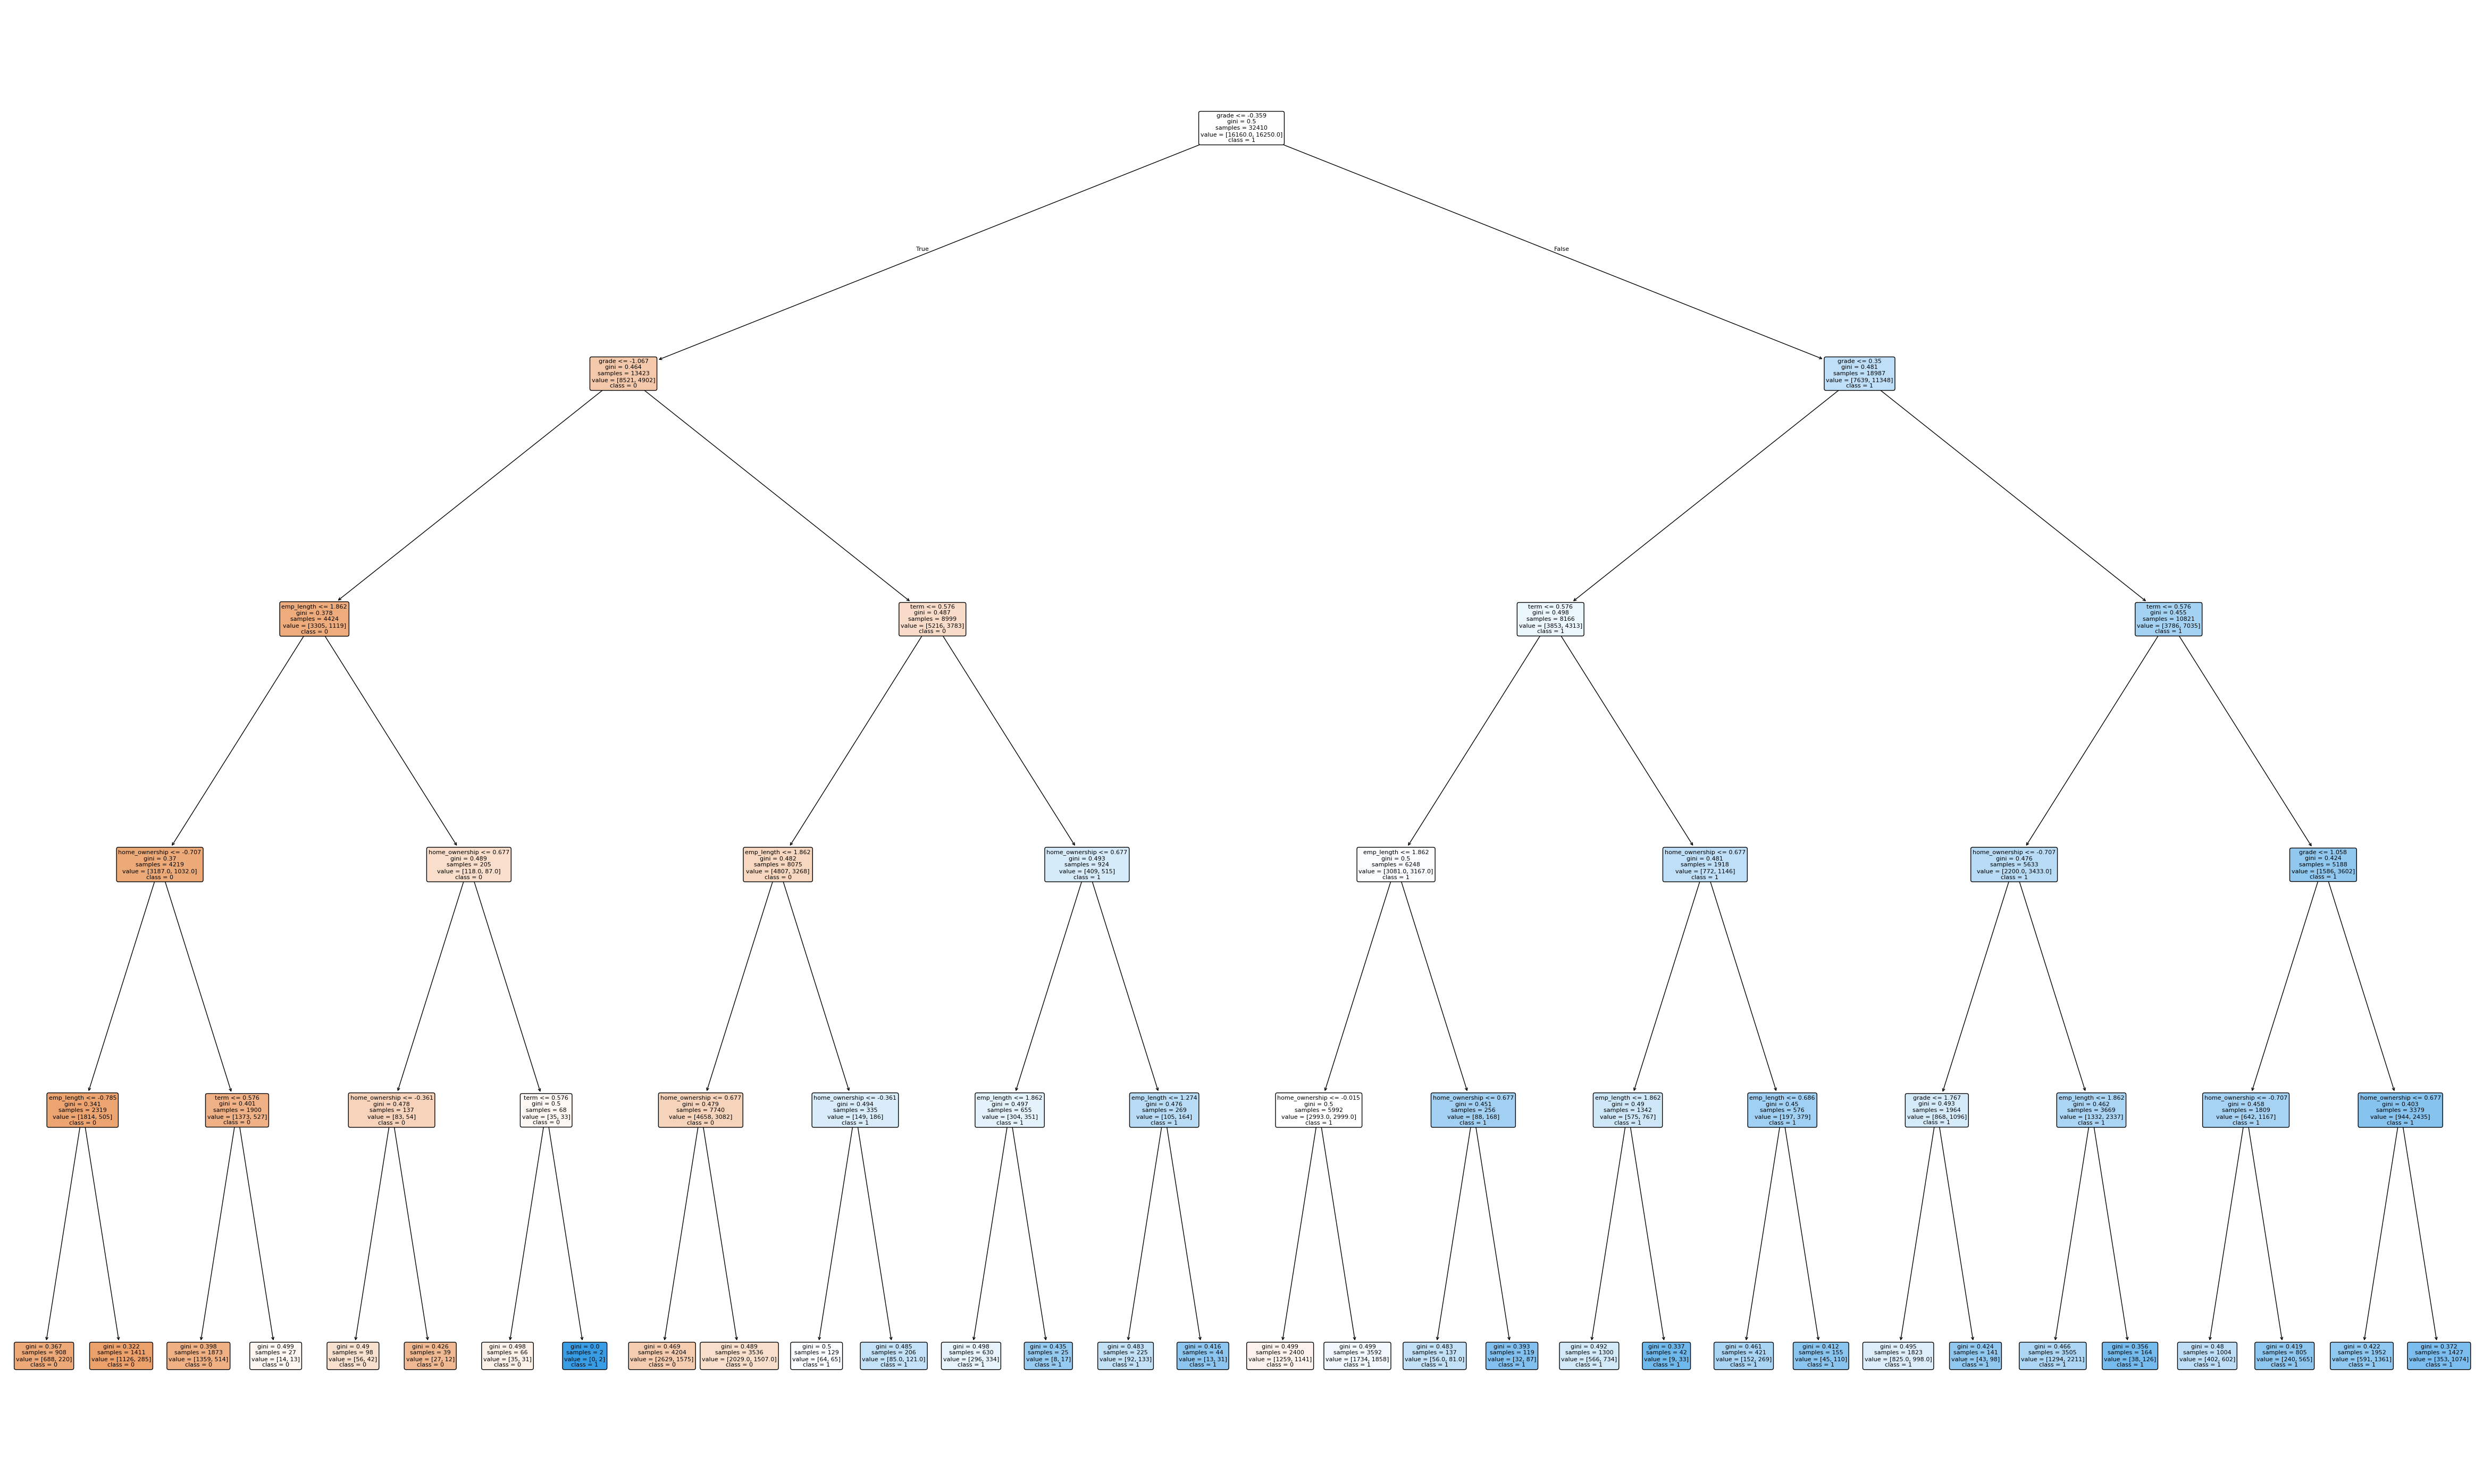

In [ ]:

def main():
    ## your code goes here ##

    X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, columns = load_and_preprocess_data('loan_sub.csv')

    ##############################################
    # optimize KNN with values in range 14
    k_values = range(865, 875)
    best_k = 1
    best_knn_val_acc = 0


    for k in k_values:
        knn = train_knn(X_train_scaled, y_train, k)
        val_acc = accuracy_score(y_val, knn.predict(X_val_scaled))
        if val_acc > best_knn_val_acc:
            best_knn_val_acc = val_acc
            best_k = k
    

    print("Best K found for KNN: ", best_k)
    ##############################################

    # optimize DT with depths 1 to 10
    depths = range(1, 11)
    best_depth = 1
    best_dt_val_acc = 0
    
    for d in depths:
        dt = train_decision_tree(X_train_scaled, y_train, d)
        val_acc = accuracy_score(y_val, dt.predict(X_val_scaled))
        if val_acc > best_dt_val_acc:
            best_dt_val_acc = val_acc
            best_depth = d
    
    print("Best depth found fot DT: ", best_depth)
    ##############################################

    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 15],
    }

    rf_base = RandomForestClassifier(random_state=42)

    grid_search = GridSearchCV(
        estimator=rf_base,
        param_grid=param_grid,
        cv=5,
        n_jobs=-1,
        scoring='accuracy'
    )

    grid_search.fit(X_train_scaled, y_train)

    best_n_trees = grid_search.best_params_['n_estimators']
    best_rf_depth = grid_search.best_params_['max_depth']


    print(f"best no. of trees found for RF: {best_n_trees}, best depth: {best_rf_depth}")


    ##############################################

    param_grid_ab = {
        'n_estimators': range(20, 80, 15)
    }

    ab_base = AdaBoostClassifier(random_state=42)

    grid_search_ab = GridSearchCV(
        estimator=ab_base,
        param_grid=param_grid_ab,
        cv=5,
        n_jobs=-1,
        scoring='accuracy'
    )

    grid_search_ab.fit(X_train_scaled, y_train)

    best_ab_n_estimators = grid_search_ab.best_params_['n_estimators']

    print(f"best n_estimators found for AdaBoost: {best_ab_n_estimators}")


    ##############################################
    


    # Train final models with best parameters
    best_knn = train_knn(X_train_scaled, y_train, best_k)
    best_dtmodel = train_decision_tree(X_train_scaled, y_train, best_depth)
    best_rf = train_rf(X_train_scaled, y_train, best_n_trees, best_rf_depth)
    best_ab = train_adaboost(X_train_scaled, y_train, n_estimators=best_ab_n_estimators)
    
    # Calculate test accuracies
    dt_test_acc = accuracy_score(y_test, best_dtmodel.predict(X_test_scaled))
    knn_test_acc = accuracy_score(y_test, best_knn.predict(X_test_scaled))
    ab_test_acc = accuracy_score(y_test, best_ab.predict(X_test_scaled))
    rf_test_acc = accuracy_score(y_test, best_rf.predict(X_test_scaled))
    



    ##################
    compare_models(dt_test_acc, knn_test_acc, ab_test_acc, rf_test_acc)

    plt.figure(figsize=(60,36))
    plot_tree(best_dtmodel, 
            feature_names=columns, 
            class_names=["0", "1"],       
            filled=True,
            rounded=True,
            fontsize=8
            )
    plt.show()


if __name__ == "__main__":
    main()